In [166]:
import os
import random
import pickle
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.inception_v3 import preprocess_input

In [167]:
plt.rcParams["figure.figsize"] = 12, 8

In [168]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Einleitung
<p style='text-align: justify; width: 1000px;'>
Als Projekt im Rahmen der Vorlesung Deep Learning wird in diesem Notebook ein Siamese Network für "Few Shot Learning" trainiert.
Few Shot Learning ist ein Teilgebiet des Maschinellen Lernens mit dem Ziel neue Daten, für die nur wenige Beispiele vorhanden sind, zu klassifizieren.
Die Aufgabe für dieses Projekt ist es eine bestimmte Person von anderen Personen zu unterscheiden. Durch Few Shot Learning kann diese Aufgabe allgemeiner gelöst werden.
Das Modell wird nicht darauf trainiert eine bestimmte Person zu klassifizieren, sondern das Modell wird darauf trainiert aus einem Bild Features zu extrahieren.
Diese Features können in der Inference dafür verwendet werden die "Ähnlichkeit" zu anderen Beispielbildern zu bestimmen.
Dadurch können Personen klassifiziert werden für die nur wenige (eins bis N) Beispielbilder in einem sogenannten "Supportset" vorhanden sind.
Das hat den Vorteil, dass Personen  im Nachhinein  in das Supportset aufgenommen und klassifiziert werden können, ohne, dass das Modell neu trainiert werden muss.
</p>

<p style='text-align: justify; width: 1000px;'>
Bei diesem Projekt handelt es sich um das Projektthema 3, mit eigenem Projektvorschlag. Daher handelt es sich um ein Projekt, bei dem kein eigenes Datenset erstellt wird. Für das Training wurde das Datenset VGG-Face-2 verwendet, das aufgrund der Größe von 40Gb nicht beigefügt ist. Für das Testen der Ausfürbarkeit ist ein kleines Datenset mit prominenten Personen beigefügt. Das Datenset wurde ursprünglich für eine App erstellt, die durch das Projekt entstanden ist. Die "Celebrity Matching" App nimmt über die Webcam Bilder vom Benutzer auf und schlägt daraufhin ähnlich aussehende Promis aus dem Supportset vor.

<p style='text-align: justify; width: 1000px;'>
Klassischerweise ist ein Siamese Network ein Modell mit zwei identischen Encoder Subnetzen, die dieselben Parameter haben.
Das Encoder Modell erzeugt aus einem Bild eine Vektorrepräsentation, die einen Punkt in einem multidimensionalen Raum darstellt.
Repräsentationen ähnlicher Inputs sollen in diesem multidimensionalen Raum nah beieinander liegen und Repräsentationen unterschiedlicher Inputs sollen weit entfernt liegen.
Um das zu erreichen wird das Modell im Training mithilfe eines Contrastive Losses darauf trainiert die Distanzen der Punkte für Inputs gleicher Kategorie zu minimieren und für Inputs unterschiedlicher Kategorie zu maximieren.
</p>

## Vorgehen
<p style='text-align: justify; width: 1000px;'>
In diesem Notebook wird das Modell durch Minimieren eines "Tripplet Losses" trainiert. Dabei handelt es sich um eine spezielle Form von Contrastive Loss, bei der drei Inputs verwendet werden.
Im Training wird jeweils ein Anchor, ein positives Beispiel und ein negatives Beispiel verwendet. Der Anchor und das positive Beispiel sind Bilder der gleichen Kategorie. Das negative Beispiel ist ein Bild einer anderen Kategorie.
Aus den drei Bildern wird die Vektorrepräsentation erzeugt und die Euklidische Distanz zwischen Anchor-Positiv und Anchor-Negativ bestimmt. Die Tripplet Loss Funktion sieht wie folgt aus:
</p>

$Loss = \max (\overline{AnchorPositive} - \overline{AnchorNegative} + Margin, 0)$

<p style='text-align: justify; width: 1000px;'>
Durch Minimieren der Loss Funktion wird die Distanz zwischen Inputs gleicher Kategorien minimiert und unterschiedlicher Kategorien maximiert, wobei der Margin Term einen Hyperparameter darstellt.
Die Distanz zwischen AnchorPositive und AnchorNegativ wird dabei so optimiert, dass die Differenz der beiden Distanzen minimal der Margin entspricht (vgl. Abbildung 1).
</p>

<p style='text-align: justify; width: 1000px;'>
Die Distanz AnchorPositive, die als positiver Term in den Loss einfließt, wird durch minimieren des Losses ebenso minimiert.
Der Term für die negative Distanz (AnchorNegative) sorgt durch das negative Vorzeichen dafür, dass diese beim Minimieren des Losses maximiert wird.

<p style='text-align: justify; width: 1000px;'>
Der Max Operator zwischen dem ersten Term und Null sorgt dafür, dass die Loss Funktion saturiert ist, wenn folgende Bedingung erfüllt ist:

$(\overline{AnchorPositive} + Margin) <= \overline{AnchorNegative}$
<p style='text-align: justify; width: 1000px;'>
Dadurch, dass die positive Distanz
nicht zwangsweise wie beim herkömmlichen Contrastive Loss auf Null optimiert wird, wird erlaubt, dass sich die bildenden Kluster auf einem größeren Raum ausbreiten können und dadurch auch Outlier inkludiert werden, aber dennoch wird dafür gesorgt, dass die Distanz zu negativen Beispielen sich mindestens um die Margin unterscheidet.
</p> 

<p style='text-align: justify; width: 1000px;'>
In der Praxis wird für das Siamese Network ein einziger Encoder verwendet, der jeweils den Anchor, das positive Beispiel und das negative Beispiel nacheinander in die Vektorrepräsentation überführt.
</p>


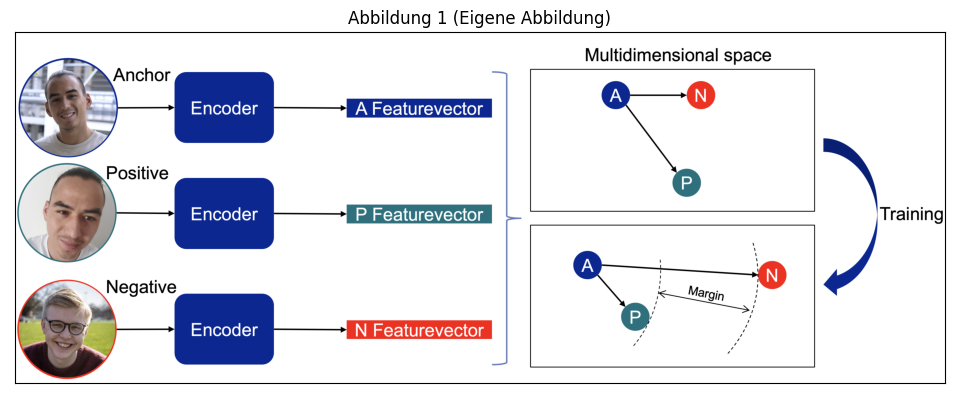

In [169]:
plt.imshow(mpimg.imread("./resources/SiameseNetwork.png"))
plt.title("Abbildung 1 (Eigene Abbildung)")
plt.xticks([])
plt.yticks([])
plt.show()
#<img src="./resources/SiameseNetwork.png" alt="Drawing" style="width: 1000px;"/>
#Abbildung 1 Eigene Abbildung

## Inference
<p style='text-align: justify; width: 1000px;'>
Während der Inference werden Beispielbilder für die zu klassifizierenden Kategorien in einem Supportset hinterlegt.
Anhand der Featurerepräsentationen der Beispielbilder und der Featuretäpresentation des Inputs kann durch die Distanz mit einem definierten Schwellenwert unterschieden werden, ob es sich bei dem Input um dieselbe Kategorie handelt oder nicht (vgl. Abbildung 2)
Das Supportset kann dafür auch bereits im Vorfeld in die Featurerepräsentation überführt werden, um die Rechenzeit während der Inference zu verkürzen.
</p>

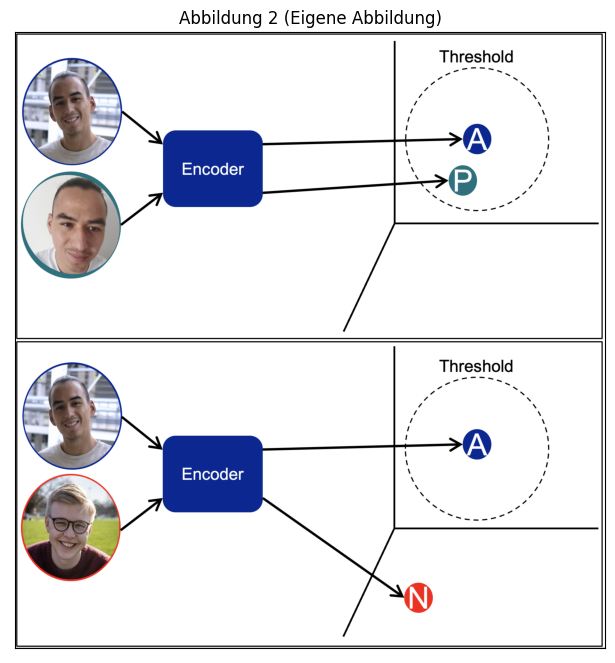

In [170]:
plt.imshow(mpimg.imread("./resources/Inference.png"))
plt.title("Abbildung 2 (Eigene Abbildung)")
plt.xticks([])
plt.yticks([])
plt.show()
#<img src="./resources/Inference.png" alt="Drawing" style="width: 700px;"/>
#Abbildung 2 Eigene Abbildung

# Datenvorverarbeitung
<p style='text-align: justify; width: 1000px;'>
Als Datenset für das Training wurde VGG-Face-2 verwendet. Durch die Größe von über 40Gb ist diesem Notebook ein anderes Datenset beigefügt.
VGG-Face-2 beinhaltet 8631 unterschiedlihce Personen mit durchschnittlich 360 Bilder pro Kategorie (oder pro Person) im Trainingsset und 500 unterschiedliche Personen im Validierungsset. Das hier beigefügte Trainingsset besteht aus prominenten Personen, da die Bilder prominenter Personen leicht zugänglich sind und da es für das Training notwendig ist, mehrere Bilder derselben Person zu haben.
</p>

<p style='text-align: justify; width: 1000px;'>
Zuerst wird das Trainingsset in Trainingsdaten und Testdaten unterteilt. Die Testdaten werden verwendet, um eventuell Overfitting zu erkennen und um im Training das Modell mit der höchsten Testgenauigkeit zu speichern.
Damit das Modell mit dem Tripplet Loss trainiert werden kann, müssen die Daten in sogenannten Tripplets vorliegen.
Diese werden generiert, indem aus jeder Kategorie alle Bilder mit allen anderen Bildern (sich selbst ausgenommen) zu Paaren kombiniert werden. Diese werden dann um ein negatives Beispiel einer anderen Kategorie erweitert.
Dadurch erhält man Tripplets bestehend aus (Anchor, Positive, Negative).
</p>

<p style='text-align: justify; width: 1000px;'>
Aus der Kombination der Bilder einer Kategorie untereinander und einem negativ Beispiel haben sich mit VGG-Face-2 über 300 Millionen Tripplets ergeben. Da aus Zeitgründen und den verfügbaren Ressourcen nichtmal eine Epoche trainiert werden kann, werden die Trainingsdaten nicht mehr wie einmal gesehen. Dadurch ist Overfitting ausgeschlossen und auf Image Augmentation wird verzichtet.

<p style='text-align: justify; width: 1000px;'>
Im folgendem Abschnitt werden Funktionen für das Laden von Bildern, das Aufteilen der Daten, das Erzeugen der Tripplets und dem Laden von Batches definiert.

<p style='text-align: justify; width: 1000px;'>
Im Vorfeld werden die Bilder mit dem Skript crop_images.py quadratisch zurechtgeschnitten. Das Skript verwendet die face_recognition Bibliothek, um Gesichter zu erkennen, sodass diese nach dem Zurechtschneiden im Fokus sind. Die beigefügten Bilder wurden bereits alle zurechtgeschnitten.

In [171]:
DATA_PATH = "./Data/Train_Celebrities_crop" # Path to trainingsdata
MAX_NUM_PER_CAT = 10 # Maximum amount of combinations within one category
MAX_NUM_PER_TEST_CAT = 3 # Maximum amount of combinations within one category

<p style='text-align: justify; width: 1000px;'>
Beim Laden der Bilder werden diese auf die Inputgröße des Modells von 300x300x3 skaliert.

In [172]:
# Function to read images from path
def read_image(file, path=DATA_PATH):
    path = os.path.join(path, file)
    image = tf.keras.preprocessing.image.load_img(path,
                                                    color_mode="rgb",
                                                    target_size=(300, 300), # Resize for specific model input shape
                                                    interpolation="bilinear")
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    return image

<p style='text-align: justify; width: 1000px;'>
Die folgende Funktion teilt die Daten in Trainings- und Testdaten auf. Danach wird zur Information die mittlere Anzahl an Bildern pro Kategorie und die Standardabweichung
ermittelt.

In [173]:
def split_dataset(directory, split=0.9):
    folders = [name for name in os.listdir(directory) if not name.endswith('.DS_Store')] # exclude .DS_Store --> MacBook specific
    num_train = int(len(folders)*split)
    random.shuffle(folders)
    
    train_list, test_list = folders[:num_train], folders[num_train:]
    
    ### ------------- Only for information ------------- 
    train_data = []
    for folder in train_list:
        train_data.append(len(os.listdir(os.path.join(directory, folder))))
    if len(train_data)>0:
        print(f"Training data with an average amount of samples per category: {np.mean(train_data)} and std: {np.std(train_data)}")
        
    test_data = []
    for folder in test_list:
        test_data.append(len(os.listdir(os.path.join(directory, folder))))
    if len(test_data)>0:
        print(f"Test data with an average amount of samples per category: {np.mean(test_data)} and std: {np.std(test_data)}")
    ### -------------  End ------------- 

    return train_list, test_list

<p style='text-align: justify; width: 1000px;'>
Aufteilen des Trainingsdatensets in 90% für die Trainingsdaten und 10% für die Testdaten.

In [174]:
train_list, test_list = split_dataset(DATA_PATH, split=0.9)

print(f"Length of training list:{len(train_list)}")
print(f"Length of testing list :{len(test_list)}")
print(f"Train list examples:{train_list[:5]}")
print(f"Test list examples:{test_list[:5]}")

Training data with an average amount of samples per category: 10.011560693641618 and std: 0.10689735265264119
Test data with an average amount of samples per category: 10.0 and std: 0.0
Length of training list:173
Length of testing list :20
Train list examples:['Rachel McAdams', 'Sylvester Stallone', 'Justin Bieber', 'Nathalie Emmanuel', 'Alice Eve']
Test list examples:['Roger Federer', 'Dwayne Johnson', 'Jennifer Lopez', 'Arnold Scharzenegger', 'Greta Tunberg']


<p style='text-align: justify; width: 1000px;'>
Die create_triplets Funktion kombiniert alle Bilder aus einer Kategorie mit allen anderen Bildern (sich selber ausgenommen).
Danach wird ein zufälliger Ordner einer anderen Kategorie gesampelt und daraus ein zufälliges Bild als negatives Beispiel ausgewählt. Die Triplets werden in einer Liste bestehend aus Ordner (Kategorie) und Dateiname von Anchor, Positive und Negative zurückgegeben. Die Bilder werden erst beim erzeugen der Batches geladen.

In [175]:
def create_triplets(directory, categories, max_files=5):
    triplets = []
    
    for category in tqdm(categories): # For every category
        path = os.path.join(directory, category)
        files = list(os.listdir(path))[:max_files] # Limit amount of files per category
        num_files = len(files)

        #random.shuffle(files)

        for i in range(num_files):
            for j in range(num_files): # Every file with every other file in the folder exept for itself
                if i==j:
                    continue # Except for itself

                anchor = os.path.join(category, files[i]) # folder and filename
                positive = os.path.join(category, files[j]) # folder and filename

                neg_category = category # Chose negative category --> any random category exept for itself
                while neg_category == category: # Make sure another category has been chosen
                    neg_category = random.choice(categories)
                
                neg_files = list(os.listdir(os.path.join(directory, neg_category)))
                neg_file = random.choice(neg_files) # Chose random file from negative folder
                negative = os.path.join(neg_category, neg_file)

                triplets.append((anchor, positive, negative)) # Append tripplet to list
            
    random.shuffle(triplets)
    return triplets

<p style='text-align: justify; width: 1000px;'>
Triplets erzeugen

In [176]:
# Load or create triplets
RECREATE_TRIPLETS = False

if RECREATE_TRIPLETS:
    train_triplet = create_triplets(DATA_PATH, train_list, max_files=MAX_NUM_PER_CAT)
    with open("./resources/train_triplet.pkl", "wb") as fp:
        pickle.dump(train_triplet, fp)
        
    test_triplet  = create_triplets(DATA_PATH, test_list, max_files=MAX_NUM_PER_TEST_CAT)
    with open("./resources/test_triplet.pkl", "wb") as fp:
        pickle.dump(test_triplet, fp)
        
else:
    with open("./resources/train_triplet.pkl", "rb") as fp:
        train_triplet = pickle.load(fp)
    with open("./resources/test_triplet.pkl", "rb") as fp:
        test_triplet = pickle.load(fp)

print(f"Number of training triplets:{len(train_triplet)}")
print(f"Number of testing triplets :{len(test_triplet)}")

print(f"Train triplet example:{train_triplet[0]}")
print(f"Test triplet example:{test_triplet[0]}")

Number of training triplets:15570
Number of testing triplets :120
Train triplet example:('Emma Stone/emma-stone,38162_1x1_xl.jpg', 'Emma Stone/images.jpeg', 'Chloë Grace Moretz/576d61001500002f001bb443.jpeg')
Test triplet example:('Margot Robbie/margot-robbie_gettyimages-870916736.jpg', 'Margot Robbie/desktop-wallpaper-margot-robbie-margot-robbie-1080x1920-thumbnail.jpg', 'Owen Wilson/MV5BMTgwMzQ4ODYxMV5BMl5BanBnXkFtZTcwNDAwMTc2NQ@@._V1_.jpg')


<p style='text-align: justify; width: 1000px;'>
Die Funktion get_Batch lädt für die Größe eines Batches jeweils die Bilder des Anchors, des positiven Beispiels und des negativen Beispiels.
An dieser Stelle könnte beispielsweise noch eine Image Augmentation eingefügt werden. Da das Datenset aber so groß ist, dass kein Tripplet mehr als einmal gesehen wird, ist hier darauf verzichtet worden.

<p style='text-align: justify; width: 1000px;'>
Die Preprocessing Funktion von InceptionV3 wird benutzt. Diese zieht den Mittelwert der Channel ab und normalisiert die Werte zwischen [-1, 1]. Obwohl InceptionV3 nicht verwendet wird, bietet dessen Preprocessing Funktion eine einfache Lösung zum normalisieren der Bilder und wird daher verwendet.

In [177]:
## Beispiel für augmentation
"""
augmentation = Sequential([
    tf.keras.layers.RandomContrast(factor, seed=None, **kwargs),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=None, **kwargs),
    tf.keras.layers.RandomRotation(factor, fill_mode="reflect", interpolation="bilinear", seed=None, fill_value=0.0, **kwargs),
    tf.keras.layers.RandomRotation(factor, fill_mode="reflect", interpolation="bilinear", seed=None, fill_value=0.0, **kwargs
    )])
"""

'\naugmentation = Sequential([\n    tf.keras.layers.RandomContrast(factor, seed=None, **kwargs),\n    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=None, **kwargs),\n    tf.keras.layers.RandomRotation(factor, fill_mode="reflect", interpolation="bilinear", seed=None, fill_value=0.0, **kwargs),\n    tf.keras.layers.RandomRotation(factor, fill_mode="reflect", interpolation="bilinear", seed=None, fill_value=0.0, **kwargs\n    )])\n'

In [178]:
def get_batch(triplet_list, path=DATA_PATH, batch_size=256, preprocessing=False):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size # Staring index at (last batch size index)
        while j<(i+1)*batch_size and j<len(triplet_list): # As long as the index j starting at (last batch size index) is below the index of ((last batch size index) + 1) * batch_size and as long as the end of the triplet list has not been reached
            a, p, n = triplet_list[j]
            anchor.append(read_image(a, path))
            positive.append(read_image(p, path))
            negative.append(read_image(n, path))
            j+=1
        
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        #  ------------- Augmentation would go here ------------- 
        #anchor = augmentation(anchor)
        #positive = augmentation(positive)
        #negative = augmentation(negative)
        # -------------------------------------------------------

        if preprocessing:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

<p style='text-align: justify; width: 1000px;'>
Beispiel Triplets

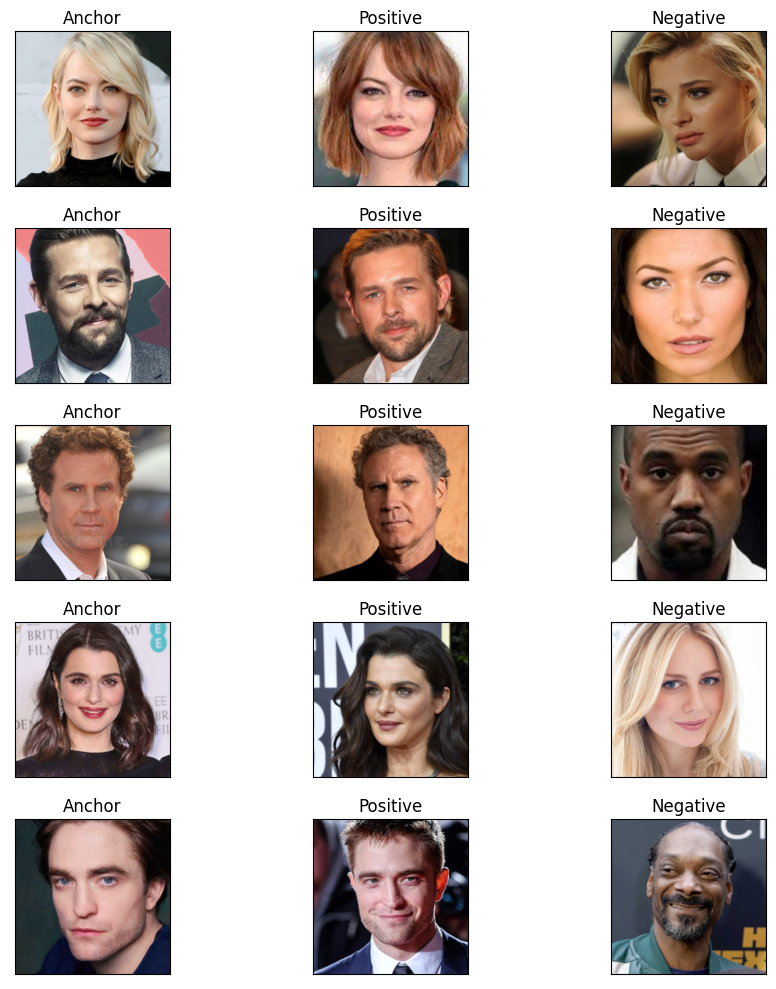

In [183]:
# Plot few triplets for verification
N = 5
plt.rcParams["figure.figsize"] = 10, 10
for (a,p,n) in get_batch(train_triplet, batch_size=N, preprocessing=False):
    c = 1
    for i in range(N):
        plt.subplot(N, 3, c)
        plt.title("Anchor")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(a[i]/255)
        plt.subplot(N, 3, c+1)
        plt.title("Positive")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(p[i]/255)
        plt.subplot(N, 3, c+2)
        plt.title("Negative")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(n[i]/255)
        c+=3
    break
#plt.savefig("./resources/Example_triplets.png", dpi=600)
plt.tight_layout()
plt.show()

# Modell

<p style='text-align: justify; width: 1000px;'>
Als Backbone für den Encoder wird ein vortrainiertes Modell von keras.applikations verwendet. Dafür stehen verschiedene Modellarchitekturen zur Auswahl.
Keras bietet auf der Seite https://keras.io/api/applications/ eine Übersicht über die verfügbaren, vortrainierten Modelle.
Anhand der Übersicht wäre das EfficientNetV2S eine sehr gute Option.
Mit Top-1 Genauigkeit von 83.9% und Top-5 Genauigkeit 96.7% und nur 21.6M Parametern bei einer Größe von 88Mb bietet diese Architektur ein sehr gutes Verhältnis zwischen Komplexität und Leistung.
</p>

<p style='text-align: justify; width: 1000px;'>
Jedoch ist die Performance damit nicht so gut ausgefallen, weshalb schlussendlich die Xception Architektur verwendet wird.
Diese Entscheidung basiert auf den Ergebnissen einer Untersuchung aus dem Jahr 2018.
In den Ergebnissen der Publikation kann gesehen werden, dass das Xception Modell ein sehr gutes Verhältnis aus Genauigkeit, Modell Größe und Anzahl an Berechnungen bietet.
</p>

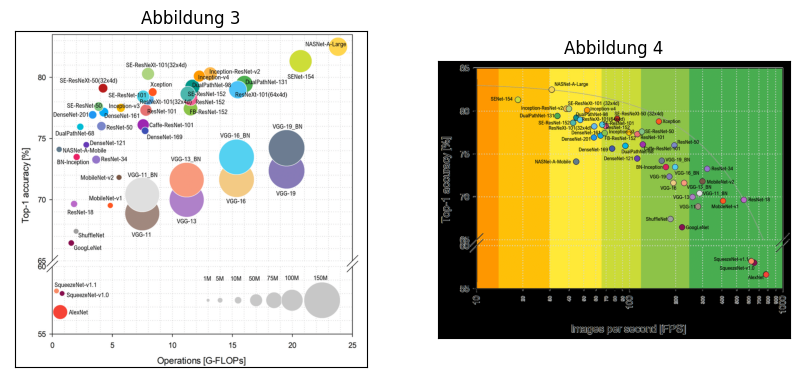

In [184]:
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread("./resources/Ball-chart-reporting-the-Top-1-and-Top-5-accuracy-vs-computational-complexity-Top-1-and.ppm"))
plt.title("Abbildung 3")
plt.xticks([])
plt.yticks([])
# <img src="./resources/Ball-chart-reporting-the-Top-1-and-Top-5-accuracy-vs-computational-complexity-Top-1-and.ppm" alt="Drawing" style="height: 700px;"/>
plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread("./resources/Top-1-accuracy-vs-number-of-images-processed-per-second-with-batch-size-1-using-the.ppm"))
plt.title("Abbildung 4")
plt.xticks([])
plt.yticks([])
# <img src="./resources/Top-1-accuracy-vs-number-of-images-processed-per-second-with-batch-size-1-using-the.ppm" alt="Drawing" style="height: 700px;"/>
plt.show()

Quelle: https://www.researchgate.net/publication/328017644_Benchmark_Analysis_of_Representative_Deep_Neural_Network_Architectures

<p style='text-align: justify; width: 1000px;'>
Das Modell wird mit auf ImageNet trainierte Parameter initialisiert und ohne die Toplayer geladen.
Für ein klassisches Klassifizierungs-Transferlearningprojekt wäre das Vorgehen, dass zunächst alle Layer des vortrainierten Netzes eingefroren werden, sodass nur die MLP Layer im Anschluss an das Backbone-Modells trainiert werden.
Danach werden ein paar Layer des Backbones trainierbar geschalten und mit einer geringeren Learningrate wird noch einmal ein Fine Tuning trainiert.

<p style='text-align: justify; width: 1000px;'>
Das Ziel dieses Projektes ist die Unterscheidung von Personen anhand von Gesichtsmerkmalen. In ImageNet gibt es Kategorien zu Tieren, Menschen, Gegenständen, etc., aber keine Kategorie, für die explizit detaillierte Gesichtsmerkmale zur unterscheidung verschiedener Gesichter notwendig wären. Daher wird vermutet, dass die auf ImageNet vortrainierten Parameter nur highlevel Gesichtsmerkmale extrahieren, um zu erkennen, ob ein Gesicht vorhanden ist oder nicht, aber keine Lowlevel Features, die für die Unterscheidung verschiedener Gesichter/Personen benötigt werden.

<p style='text-align: justify; width: 1000px;'>
Im Training werden in den früheren Layern High Level Features gelernt, die mit voranschreitender Tiefe in den späteren Layern zu Low Level Features in Bezug zu den Kategorien kombiniert werden. Wie bereits erwähnt, gibt es in ImageNet keine Gesichtsspezifischen Kategorien und da die Features in bezug zu den im Training verwendeten Kategorien gelernt werden, wird vermutet, dass die Low Level Feature in den tieferen Layern viele Informationen in Bezug zu unterschidlichen Gesichtszügen vernachlässigen könnten. <br>
Aus diesem Grund wird bereits von Anfang an ein Großteil der Parameter des vortrainierten Xception Modells trainierbar geschalten, um zu ermöglichen, dass bereits aus den anfänglichen High Level Feature gute Low Level Feature in Bezug zu unterschiedlichen Gesichtsmerkmalen gelernt werden können.

<p style='text-align: justify; width: 1000px;'>
Im Anschluss an das Backbone Modell wird ein MLP bestehend aus vier Fully-Connected-Layer verwendet. Diese verwenden als Aktivierungsfunktion ReLu.
Zudem wird Dropout verwendet, um das Modell robuster zu trainieren, indem zufällig eine gewisse Anzahl an Verbindungen vernachlässigt werden.
Die letzte Layer verwendet keine Aktivierungsfunktion. Die Begründung dafür ist, dass ReLu dafür sorgt, dass der Output >= 0 ist.
Im Fall von einem 2D Vektor würde das Bedeuten, dass der Output auf den ersten Quadranten begrenzt ist.
Ohne ReLu aktivierung können die Einträge des Vektors auch negativ sein, was ermöglicht, dass der Output in allen vier Quadranten liegen kann.
Dadurch wird der Raum, in dem die multidimensionalen Featurevektoren liegen können, vergrößert. Dadurch wird mehr Platz geboten, um die unterschiedlichen Personen, bzw. deren Merkmale, im Raum zu verteilen.

<p style='text-align: justify; width: 1000px;'>
Die L2 Normalisierung zum Schluss teilt den Featurevektor durch seinen Betrag und bildet dadurch daraus einen Einheitsvektor.
Das sorgt dafür, dass die verschiedenen Dimensionen des Featurevektors im Vergleich untereinander gleich gewichtet werden.

In [185]:
def get_encoder(input_shape = (300, 300, 3), pretrained_trainable_layers:int = 27):

    """
    pretrained_model = tf.keras.applications.EfficientNetV2S(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="max",
        include_preprocessing=True,
        )
    """

    # Backbone Modell auf ImageNet vortrainiert
    pretrained_model = tf.keras.applications.Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    # Einfrieren der Layer
    for i in range(len(pretrained_model.layers)-pretrained_trainable_layers):
        pretrained_model.layers[i].trainable = False

    # MLP
    encoder_model = Sequential([
        pretrained_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(256, activation="relu"),
        Dropout(0.05),
        BatchNormalization(),
        Dense(128, activation=None),
        Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        ], name="Encoder_Model")
    
    return encoder_model

encoder = get_encoder(input_shape = (300, 300, 3), pretrained_trainable_layers = 27)
encoder.compile()
encoder.summary()

Model: "Encoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_25 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                     

# Training

<p style='text-align: justify; width: 1000px;'>
Für das Training wird der Adam Optimizer verwendet, dieser arbeitet mit adaptivem Momentum, um lokale Minima zu überwinden. Zudem wird die Obergrenze der Learning Rate durch einen Cosine Scheduler mit der Zeit verringert. Durch Verwenden des Cosine Schedulers mit Restarts, wird die Learning Rate über eine Periode zu Null verringert, danach wird die Learning Rate wieder auf den maximalen Wert zurückgesetz und mit jeder weiteren Periode wird die dauer für das Verringern verdoppelt. Das sorgt auch nochmal dafür, dass durch die Restarts lokale Minima überwunden werden können. Zum Ende, wenn die Perioden lang genug werden, wird durch das langsame verringern der Learning Rate in dem aktuellen Minimum das Optimum gefunden.

In [186]:
# Training Hyperparameters
MARGIN = 1.0
EPOCHS = 200 # Maximale Anzahl an Epochen
BATCH_SIZE = 5 # Quite small Batch size due to hardware
NAME = "Run_01" # Name for tensorboard logger
MODEL_SAVE_PATH = "saved_models"

lr = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=1e-4, first_decay_steps=1_000, t_mul=2.0, m_mul=1.0, alpha=0.0)
optimizer = Adam(learning_rate=lr)

<p style='text-align: justify; width: 1000px;'>
Die evaluate Funktion testet die aktuelle Performance anhand des Testsets. Dabei werden alle Triplets in die Featurerepräsentation
überführt und die Distanzen zwischen Anchor-Positiv und Anchor-Negativ bestimmt. Für die Accuracy Metrik wird überprüft, wie viele der AnchorPositiv Paare eine Distanz kleiner als die Margin haben und wie viele der AnchorNegativ Paare eine Distanz größer als die Margin haben. 
<p style='text-align: justify; width: 1000px;'>
Diese Metrik ist nicht ganz korrekt, weil die Distanz Anchor-Positive nicht explizit darauf optimiert wird kleiner zu sein wie die Margin und die Distanz Anchor-Negativ auch nicht explizit darauf optimiert wird größer zu sein wie die Margin, sondern das Modell wird darauf optimiert, dass

$(\overline{AnchorPositive} + Margin) <= \overline{AnchorNegative}$
<p style='text-align: justify; width: 1000px;'>
gilt. Im Training zeigt sich, dass dieser Ansatz dennoch ein guter Indikator für die tatsächliche Performance ist. Zusätzlich wird noch überprüft, wie viel Prozent der Positiven Beispiele eine geringere Distanz im Vergleich zu den Negativen Beispielen haben. Die durchschnittlichen Distanzen, sowie deren Standardabweichungen werden ebenso abgespeichert.

In [187]:
def evaluate(encoder, summary_writer, test_triplet, step, path, mode=""):
    ap_distances, an_distances = [], []

    for (anchor, positive, negative) in get_batch(test_triplet, batch_size=BATCH_SIZE, path=path, preprocessing=True):
        if len(anchor.shape)>1:
            anchor_representation = encoder(anchor)
            positive_representation = encoder(positive)
            negative_representation = encoder(negative)
            ap_distances.extend(tf.reduce_sum((anchor_representation - positive_representation)**2, axis=-1).numpy())
            an_distances.extend(tf.reduce_sum((anchor_representation - negative_representation)**2, axis=-1).numpy())
    
    test_accuracy = np.mean([np.array(ap_distances) < MARGIN, np.array(an_distances) > MARGIN])
    test_metric = np.mean(np.array(ap_distances) < np.array(an_distances))
    with summary_writer.as_default():
        tf.summary.scalar(f"{mode} Test accuracy", test_accuracy, step)
        tf.summary.scalar(f"{mode} Test negative distance bigger than positive distance", test_metric, step)
        tf.summary.scalar(f"{mode} Test Mean anchor positive distance", np.mean(ap_distances), step)
        tf.summary.scalar(f"{mode} Test Mean anchor negative distance", np.mean(an_distances), step)
        tf.summary.scalar(f"{mode} Test STD anchor positive distance", np.std(ap_distances), step)
        tf.summary.scalar(f"{mode} Test STD anchor negative distance", np.std(an_distances), step)
    
    return test_accuracy

<p style='text-align: justify; width: 1000px;'>
Der Tensorboard Aufruf muss oftmals zwei Mal ausgeführt werden, dass dieser funktioniert.
Wird das Tensorboard im Jupyter Notebook vor dem Start des Trainings ausgeführt, kann der Trainingsfortschritt beobachtet werden. Alternativ kann ein Tensorboard jederzeit separat über ein Terminal geöffnet werden.

In [188]:
# Probably needs to be executed twice
# Should be started before execution of train loop
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 86723), started 1 day, 6:48:26 ago. (Use '!kill 86723' to kill it.)

<p style='text-align: justify; width: 1000px;'>
Für das Training wird eine custom Trainingsloop verwendet. Da das Modell hintereinander den Anchor, das positive und negative Beispiel verarbeitet ist eine custom Loop die einfachere Variante. Zuerst wird das Tensorboard initialisiert und dann startet die Trainingsschleife. Alle 1000 Schritte wird die Performance getestet und ein Modell abgespeichert, wenn die Test Accuracy besser wird.

<p style='text-align: justify; width: 1000px;'>
Der interessante Part ist im folgenden Abschnitt die bestimmung der Distanzen und die Loss Funktion. tf.GradientTape wird verwendet, um die Gradienten abhängig von den trainierbaren Parametern und der Loss Funktion zu bestimmen.

In [ ]:
max_acc = 0
step = 0

os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

log_dir = 'logs/' + NAME
summary_writer = tf.summary.create_file_writer(log_dir)

for epoch in tqdm(range(1, EPOCHS+1)):


    for (anchor, positive, negative) in get_batch(train_triplet, batch_size=BATCH_SIZE, path=DATA_PATH, preprocessing=True):
        if len(anchor.shape)>1:
            with tf.GradientTape() as tape:
                
                anchor_representation = encoder(anchor)
                positive_representation = encoder(positive)
                negative_representation = encoder(negative)

                ap_distance = tf.reduce_sum((anchor_representation - positive_representation)**2, axis=-1)
                an_distance = tf.reduce_sum((anchor_representation - negative_representation)**2, axis=-1)

                loss = tf.reduce_mean(tf.maximum(ap_distance - an_distance + MARGIN, 0.0))
            gradients = tape.gradient(loss, encoder.trainable_variables)
            optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))

            train_accuracy = np.mean([np.array(ap_distance) < MARGIN, np.array(an_distance) > MARGIN])
            train_test_metric = np.mean(np.array(ap_distance) < np.array(an_distance))
            with summary_writer.as_default():
                tf.summary.scalar(f"Train accuracy", train_accuracy, step)
                tf.summary.scalar(f"Train negative distance bigger than positive distance", train_test_metric, step)
                tf.summary.scalar(f"Train Mean anchor positive distance", np.mean(ap_distance), step)
                tf.summary.scalar(f"Train Mean anchor negative distance", np.mean(an_distance), step)
                tf.summary.scalar(f"Train STD anchor positive distance", np.std(ap_distance), step)
                tf.summary.scalar(f"Train STD anchor negative distance", np.std(an_distance), step)

                tf.summary.scalar("Loss", loss, step)

            if step%100==0:
                test_accuracy = evaluate(encoder, summary_writer, test_triplet, step, DATA_PATH)

                if test_accuracy>=max_acc:
                    max_acc = test_accuracy
                    encoder.save(f"./{MODEL_SAVE_PATH}/best_encoder_{step}_step_acc_{str(round(max_acc, 4)).replace('.', '_')}.h5")
                        
            step += 1

    test_accuracy = evaluate(encoder, summary_writer, test_triplet, epoch, DATA_PATH, mode="Epoch")
    if test_accuracy>=max_acc:
        max_acc = test_accuracy
        encoder.save(f"./{MODEL_SAVE_PATH}/best_encoder_{epoch}_epoch_acc_{str(round(max_acc, 4)).replace('.', '_')}.h5")

        
encoder.save(f"./{MODEL_SAVE_PATH}/final_encoder_model.h5")

# Trainingsverlauf Analyse
<p style='text-align: justify; width: 1000px;'>
Im nächsten Abschnitt werden die während dem Training aufgezeichneten Variablen untersucht, dafür wird die gespeicherte Tensorflow SummaryWriter Datei geladen und konvertiert. Weil diese Datei über 300Mb groß ist, wird eine bereits konvertierte JSON Datei im Projekt mit abgegeben und im folgenden geladen.

<p style='text-align: justify; width: 1000px;'>
Der SummaryReader von tbparse wird verwendet, um den Trainingsverlauf aus dem Tensorboard Format in eine json Datei zu konvertieren. Im folgenden wird der Verlauf des Trainings mit dem VGG-Face-2 Dataenset geladen und analysiert.

In [35]:
"""
from tbparse import SummaryReader
log_dir = "./logs"
directory = "Run_06"
file_name = os.listdir(os.path.join(log_dir, directory))[0]

path = os.path.join(log_dir, directory, file_name)
reader = SummaryReader(path)
df = reader.tensors

dict = {}
keys = ['Loss',
 'Train accuracy',
 'Test accuracy',
 'Train negative distance bigger than positive distance',
 'Test negative distance bigger than positive distance',
 'Train Mean anchor positive distance',
 'Test Mean anchor positive distance',
 'Train Mean anchor negative distance',
 'Test Mean anchor negative distance',
 'Train STD anchor positive distance',
 'Test STD anchor positive distance',
 'Train STD anchor negative distance',
 'Test STD anchor negative distance']

 for tag in keys:
    data = df.loc[df['tag'] == tag].values
    steps = data[:,1]
    values = data[:,3]
    idx = np.array(steps)<=51000 # For all steps smaller than
    dict[tag] = {"Steps": list(steps[idx]), "Values": list(values[idx])}

with open("./train_history.json", "w") as f:
    json.dump(dict, f)
"""

'\nfrom tbparse import SummaryReader\nlog_dir = "./logs"\ndirectory = "Run_06"\nfile_name = os.listdir(os.path.join(log_dir, directory))[0]\n\npath = os.path.join(log_dir, directory, file_name)\nreader = SummaryReader(path)\ndf = reader.tensors\n\ndict = {}\nkeys = [\'Loss\',\n \'Train accuracy\',\n \'Test accuracy\',\n \'Train negative distance bigger than positive distance\',\n \'Test negative distance bigger than positive distance\',\n \'Train Mean anchor positive distance\',\n \'Test Mean anchor positive distance\',\n \'Train Mean anchor negative distance\',\n \'Test Mean anchor negative distance\',\n \'Train STD anchor positive distance\',\n \'Test STD anchor positive distance\',\n \'Train STD anchor negative distance\',\n \'Test STD anchor negative distance\']\n\n for tag in keys:\n    data = df.loc[df[\'tag\'] == tag].values\n    steps = data[:,1]\n    values = data[:,3]\n    idx = np.array(steps)<=51000 # For all steps smaller than\n    dict[tag] = {"Steps": list(steps[idx]), "

In [189]:
plt.rcParams["figure.figsize"] = 8, 5

In [190]:
with open("./logs/train_history.json", "r") as f:
    history = json.load(f)

In [191]:
# Polyak averaging
def get_moving_average(data, tau=0.999):
    ma = [data[0]]
    for value in data:
        ma.append(ma[-1] * tau + (1 - tau) * value)
    return ma[1:]

<p style='text-align: justify; width: 1000px;'>
Der unten zu sehende Plot zeigt den Loss über den Trainingsschritten. Die Schwankungen bei 100 000 und 300 000 entstehen durch die Resets der Learning Rate durch den Cosine Scheduler. Ansonsten zeigt der Loss einen konstant sinkenden Verlauf.

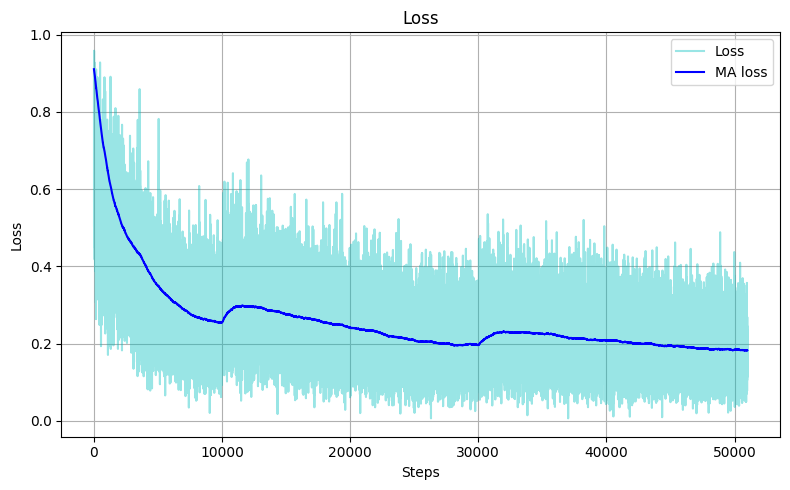

In [192]:
plt.plot(history["Loss"]["Steps"], history["Loss"]["Values"], 'c', alpha=0.4, label="Loss")
plt.plot(history["Loss"]["Steps"], get_moving_average(history["Loss"]["Values"]), 'b', label="MA loss")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.legend()
plt.grid()
plt.tight_layout()

<p style='text-align: justify; width: 1000px;'>
Die nächsten Plots zeigen die Accuracy und ob die positiven Beispiele eine geringere Distanz haben als die negativen Beispiele.
Da durch die Größe des Datensets kein Sample mehr als einmal verwendet wird, kann es nicht zu Overfitting kommen. Ansonsten kann durch die Visualisierung der
Trainings- und Testaccuracy erkannt werden, ob es zu Overfitting kommt, indem die Trainingsaccuracy weiter steigt, während die Testaccuracy sinkt. Auch hier können wieder die Einbrüche durch die Resets der Learningrate gesehen werden.

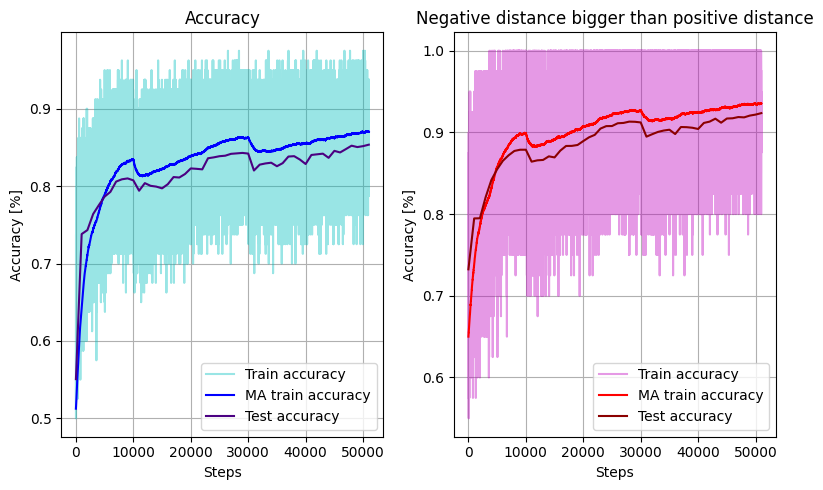

In [193]:
plt.subplot(1, 2, 1)
plt.plot(history["Train accuracy"]["Steps"], history["Train accuracy"]["Values"], 'c', alpha=0.4, label="Train accuracy")
plt.plot(history["Train accuracy"]["Steps"], get_moving_average(history["Train accuracy"]["Values"]), 'b', label="MA train accuracy")
plt.plot(history["Test accuracy"]["Steps"], history["Test accuracy"]["Values"], 'indigo', label="Test accuracy")
plt.title("Accuracy")
plt.ylabel("Accuracy [%]")
plt.xlabel("Steps")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history["Train negative distance bigger than positive distance"]["Steps"], history["Train negative distance bigger than positive distance"]["Values"], 'm', alpha=0.4, label="Train accuracy")
plt.plot(history["Train negative distance bigger than positive distance"]["Steps"], get_moving_average(history["Train negative distance bigger than positive distance"]["Values"]), 'r', label="MA train accuracy")
plt.plot(history["Test negative distance bigger than positive distance"]["Steps"], history["Test negative distance bigger than positive distance"]["Values"], 'darkred', label="Test accuracy")
plt.title("Negative distance bigger than positive distance")
plt.ylabel("Accuracy [%]")
plt.xlabel("Steps")
plt.legend()
plt.grid()
plt.tight_layout()

<p style='text-align: justify; width: 1000px;'>
Die Distanzen in den unten zu sehenden Plots konvergieren nach 100 000 Schritten relativ schnell, was dafür sprchen würde, das Training bereits nach 100 000 Schritten zu beenden. Schaut man aber auf den übernächsten Plot, der die Standardabweichungen der Distanzen darstellt, kann gesehen werden, dass diese weiterhin sinken. Es wird vermutet, dass sich die Positionen im Multidimensionalen Raum durch das längere Training gleichmäßiger Verteilen und ähnliche Inputs zu ähnlichen Repräsentationen gemappt werden, was zur Folge hat, dass die Abstände konsistenter werden.

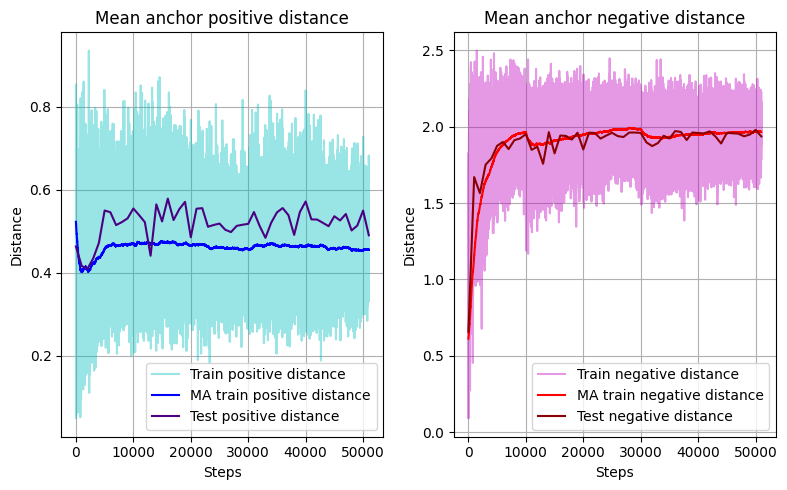

In [194]:
plt.subplot(1, 2, 1)
plt.plot(history["Train Mean anchor positive distance"]["Steps"], history["Train Mean anchor positive distance"]["Values"], 'c', alpha=0.4, label="Train positive distance")
plt.plot(history["Train Mean anchor positive distance"]["Steps"], get_moving_average(history["Train Mean anchor positive distance"]["Values"]), 'b', label="MA train positive distance")
plt.plot(history["Test Mean anchor positive distance"]["Steps"], history["Test Mean anchor positive distance"]["Values"], 'indigo', label="Test positive distance")
plt.title("Mean anchor positive distance")
plt.ylabel("Distance")
plt.xlabel("Steps")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history["Train Mean anchor negative distance"]["Steps"], history["Train Mean anchor negative distance"]["Values"], 'm', alpha=0.4, label="Train negative distance")
plt.plot(history["Train Mean anchor negative distance"]["Steps"], get_moving_average(history["Train Mean anchor negative distance"]["Values"]), 'r', label="MA train negative distance")
plt.plot(history["Test Mean anchor negative distance"]["Steps"], history["Test Mean anchor negative distance"]["Values"], 'darkred', label="Test negative distance")
plt.title("Mean anchor negative distance")
plt.ylabel("Distance")
plt.xlabel("Steps")
plt.legend()
plt.grid()
plt.tight_layout()

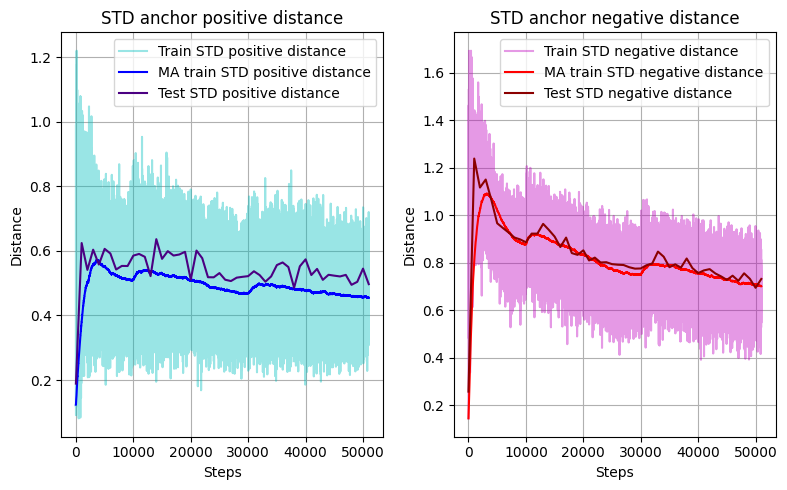

In [195]:
plt.subplot(1, 2, 1)
plt.plot(history["Train STD anchor positive distance"]["Steps"], history["Train STD anchor positive distance"]["Values"], 'c', alpha=0.4, label="Train STD positive distance")
plt.plot(history["Train STD anchor positive distance"]["Steps"], get_moving_average(history["Train STD anchor positive distance"]["Values"]), 'b', label="MA train STD positive distance")
plt.plot(history["Test STD anchor positive distance"]["Steps"], history["Test STD anchor positive distance"]["Values"], 'indigo', label="Test STD positive distance")
plt.title("STD anchor positive distance")
plt.ylabel("Distance")
plt.xlabel("Steps")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history["Train STD anchor negative distance"]["Steps"], history["Train STD anchor negative distance"]["Values"], 'm', alpha=0.4, label="Train STD negative distance")
plt.plot(history["Train STD anchor negative distance"]["Steps"], get_moving_average(history["Train STD anchor negative distance"]["Values"]), 'r', label="MA train STD negative distance")
plt.plot(history["Test STD anchor negative distance"]["Steps"], history["Test STD anchor negative distance"]["Values"], 'darkred', label="Test STD negative distance")
plt.title("STD anchor negative distance")
plt.ylabel("Distance")
plt.xlabel("Steps")
plt.legend()
plt.grid()
plt.tight_layout()

<p style='text-align: justify; width: 1000px;'>
Anhand des Trainingsverlaufs kann gesehen werden, dass das Training für den weiteren Verlauf noch Potenzial gehabt hätte. Die Accuracy, sowie die STD Plots zeigen, dass diese noch nicht vollständig konvergiert haben. Aus Zeitlichen und Ressourcen Gründen ist das Training jedoch nach knapp einer Wochen beendet worden. Das beste Modell ist nach 505 000 Trainingsschritten mit einer Testgenauigkeit von 90,13% gespeichert worden. Im nächsten Kapitel wird die Performance durch Tunen eines Schwellenwertes zur Unterscheidung verschiedener Personen weiter gesteigert. Außerdem werden Analysen zur Performance, sowie Visualisierungen für potenzielle Verbesserungen, bzw. Fehlerquellen durchgeführt.

# Evaluation

<p style='text-align: justify; width: 1000px;'>
In dem letzten Abschnitt wird die Performance anhand von einer Confusion Matrix evaluiert. Anschließend wird durch Bestimmen eines optimalen Schwellenwerts die Performance nocheinmal verbessert. Zudem wird diskutiert, wie die Auswahl des Schwellenwertes einen Einfluss auf die False Positives und False Negatives hat. Zur Visualisierung werden Repräasentationen mehrerer Personen durch TSNE und PCA auf zwei Dimensionen reduziert und es kann gezeigt werden, dass die unterschiedlichen Personen Kluster bilden. Es werden Beispiele zu False Positive Predictions und zu False Negative Predictions geplottet und anhand der Visualisierungen auf vermeintliche Fehlerquellen geschlossen. Zum Schluss wird ein Beispiel zur Identifikation von mir selber im Vergleich zu jemand Anderen gezeigt.

In [196]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.rcParams["figure.figsize"] = 10, 10

In [197]:
# Modell laden
MODEL_PATH = "saved_models"
MODEL_NAME = "best_encoder_505000_step_acc_0_9013.h5"
encoder = tf.keras.models.load_model(os.path.join(MODEL_PATH, MODEL_NAME), compile=False)

<p style='text-align: justify; width: 1000px;'>
Zur Evaluierung wird das Validation Set verwendet. Dafür werden wie bereits für das Training Triplets gebildet.

In [198]:
MAX_NUM_PER_VAL_CAT = 10
VAL_PATH = "./Data/Val_Celebrities_crop"
CREATE_TRIPLETS = False

if CREATE_TRIPLETS:
    _, val_list = split_dataset(VAL_PATH, split=0.0)
    print(f"Length of testing list :{len(val_list)}")
    print(f"Train List:{val_list}")

    val_triplet = create_triplets(VAL_PATH, val_list, max_files=MAX_NUM_PER_VAL_CAT)
    with open("./resources/val_triplet.pkl", "wb") as fp:
        pickle.dump(val_triplet, fp)

else:
    with open("./resources/val_triplet.pkl", "rb") as fp:
        val_triplet = pickle.load(fp)

print(f"Amount triplets {len(val_triplet)}")

Amount triplets 1782


## Confusion Matrix

<p style='text-align: justify; width: 1000px;'>
Zuerst wird die Performance mit der Margin als Schwellenwert getestet. Die damit ermittelte Genauigkeit und Confusion Matrix dient als Vergleichswert für das folgende Tuning. Die Distanzen werden in einem Array gespeichert, im nachhinein werden diese verwendet, um daraus den bestmöglichen Schwellenwert zu finden.

In [199]:
THRESHOLD = 1.0 # Same as Margin

predictions = np.array([])
labels = []
ap_distances, an_distances = [], []
for (anchor, positive, negative) in get_batch(val_triplet, path=VAL_PATH, preprocessing=True):
    if len(anchor.shape)>1:
        anchor_representation = encoder(anchor)
        positive_representation = encoder(positive)
        negative_representation = encoder(negative)

        ap_distance = tf.reduce_sum((anchor_representation - positive_representation)**2, axis=-1).numpy()
        an_distance = tf.reduce_sum((anchor_representation - negative_representation)**2, axis=-1).numpy()

        ap_distances.extend(ap_distance)
        an_distances.extend(an_distance)
        predictions = np.concatenate([predictions, ap_distance<THRESHOLD, an_distance<THRESHOLD], axis=0)
        labels = np.concatenate([labels, [True] * len(ap_distance), [False] * len(an_distance)], axis=0)

cm = confusion_matrix(labels, predictions, normalize='true')
accuracy = np.mean(predictions == labels)

<p style='text-align: justify; width: 1000px;'>
Das Modell kann mit einer Genauigkeit von 94,14% Personen im Validation Set unterscheiden.
Die Confusion Matrix ist so normiert, dass alle Ground Truth Negatives (Also True Negative und False Positive) zusammen 100% ergeben und dass alle Ground Truth Positives (Also False negative und True positive zusammen) 100% ergeben. D.h. dass die Werte auf die Anzahl an Ground Truth negativ Beispielen und auf die Anzahl an Ground Truth positiven Beispielen normiert sind und eine Zeile in Summe 100% ergibt.

<p style='text-align: justify; width: 1000px;'>
In der Confusion Matrix kann gesehen werden, dass mit dem gewählten Schwellenwert das Modell eher dazu tendiert falsche Personen als richtig zu identefizieren (10,27% von allen falschen Personen werden als gleiche Person identifiziert), als eine richtige Person als falsch zu klassifizieren (1,46% aller richtigen Personen werden als andere Person identifiziert).

With an accuracy of 0.94136


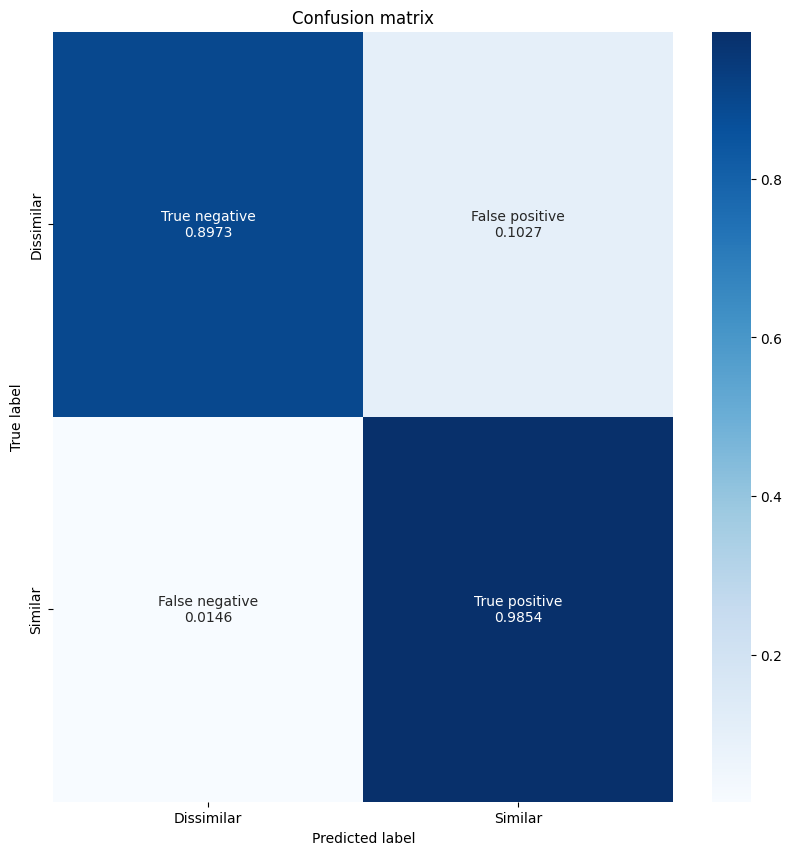

In [200]:
cm = confusion_matrix(labels, predictions, normalize='true')

cm_labels = np.asarray([f'True negative\n{round(cm[0,0],4)}', f'False positive\n{round(cm[0,1],4)}',f'False negative\n{round(cm[1,0],4)}', f'True positive\n{round(cm[1,1],4)}']).reshape(2,2)
ax = sns.heatmap(cm, annot=cm_labels, cmap = 'Blues', fmt='')
ax.set(xlabel='Predicted label', ylabel='True label')
ax.set_title("Confusion matrix")
ax.set_xticklabels(['Dissimilar', 'Similar'])
ax.set_yticklabels(['Dissimilar', 'Similar'])
print(f"With an accuracy of {round(accuracy,5)}")

<p style='text-align: justify; width: 1000px;'>
Durch Auswählen eines optimalen Schwellenwertes kann die Performance gesteigert werden. Der nächste Abschnitt bestimmt aus den gespeicherten Distanzen des Validation Sets mit unterschiedlichen Schwellenwerten die Genauigkeit. Der Schwellenwert mit dem kleinsten, gemeinsamen Fehler wird ermittelt.
Dadurch kann die Genauigkeit auf 94,28% um 0,14% gesteigert werden.

In [201]:
THRESHOLDS = np.arange(0.0,3,0.001)

cms = []
accuracies = []
thresholds = []
false_positive = []
false_negative = []

for threshold in THRESHOLDS:

    prediction = np.concatenate([ap_distances<threshold, an_distances<threshold], axis=0)
    label = np.concatenate([[True] * len(ap_distances), [False] * len(an_distances)], axis=0)

    false_positive.append(np.mean(an_distances<threshold))
    false_negative.append(np.mean(ap_distances>threshold))

    cms.append(confusion_matrix(label, prediction, normalize='true'))
    accuracies.append(np.mean([np.array(ap_distances) < threshold, np.array(an_distances) > threshold]))
    thresholds.append(threshold)

idx = np.flip(np.argsort(accuracies))
accuracies = [accuracies[i] for i in idx]
thresholds = [thresholds[i] for i in idx]
cms = [cms[i] for i in idx]

Der nächste Plot zeigt die Confusion Matrix nach dem Tuning mit einem Schwellenwert von 0,914

With an accuracy of 0.94276 and a threshold of 0.914


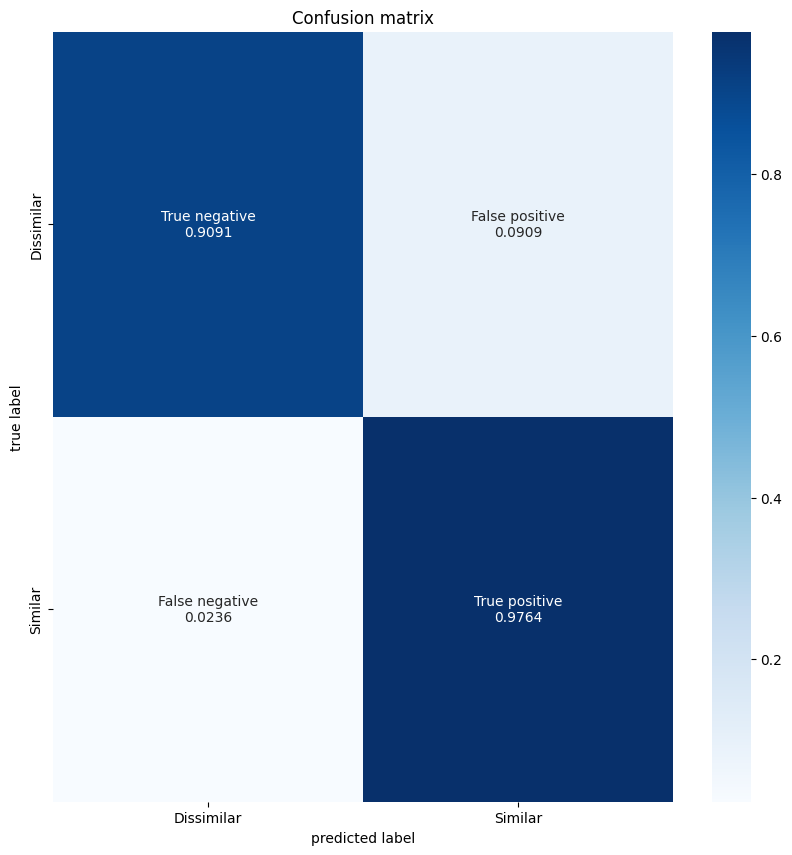

In [202]:
cm = cms[0]
cm_labels = np.asarray([f'True negative\n{round(cm[0,0],4)}', f'False positive\n{round(cm[0,1],4)}',f'False negative\n{round(cm[1,0],4)}', f'True positive\n{round(cm[1,1],4)}']).reshape(2,2)
ax = sns.heatmap(cm, annot=cm_labels, cmap = 'Blues', fmt='')
ax.set(xlabel='predicted label', ylabel='true label')
ax.set_title("Confusion matrix")
ax.set_xticklabels(['Dissimilar', 'Similar'])
ax.set_yticklabels(['Dissimilar', 'Similar'])
print(f"With an accuracy of {round(accuracies[0],5)} and a threshold of {round(thresholds[0], 4)}")

## Priorisierung der Prediction
<p style='text-align: justify; width: 1000px;'>
Durch Auswählen des Schwellenwertes kann die Wichtigkeit der False Positives und False Negatives priorisiert werden. Im nächsten Plot kann die Auswirkung des Schwellenwertes auf das Ergebnis gesehen werden. In blau sind die False Negatives zu sehen, in orange die False Positives und in grün die normaliserte Kombination aus beiden. Je nach Anwendung kann anhand dieses Graphen die Priorisierung gewählt werden. Ist der Schwellenwert Null, werden alle richtigen Personen als falsch erkannt, dafür werden aber auch alle falschen Personen als falsch erkannt. Ist der Schwellenwert zu hoch, werden immer mehr falsche Peronen als richtig erkannt, dafür werden aber auch alle richtigen Personen als richtig erkannt.

<p style='text-align: justify; width: 1000px;'>
Je nach Anwendung kann es wichtiger sein, dass für eine hohe Sicherheit die Anzahl an False Positives gering ausfällt, aber dafür in kauf genommen wird, dass eventuell eine richtige Person nicht als diese erkannt wird.

<p style='text-align: justify; width: 1000px;'>
Ein anderer Anwendungsfall könnte beispielsweise die Einlasskontrolle eines Klubs sein, bei dem es dem Besitzer wichtiger ist, dass ein VIP Gast auf jeden Fall erkannt wird, dafür aber auch ein paar falsche Personen rein gelassen werden.

<p style='text-align: justify; width: 1000px;'>
So kann die Performance durch die Wahl eines entsprchenden Schwellenwertes auf die Priorität der Anwendung angepasst werden.

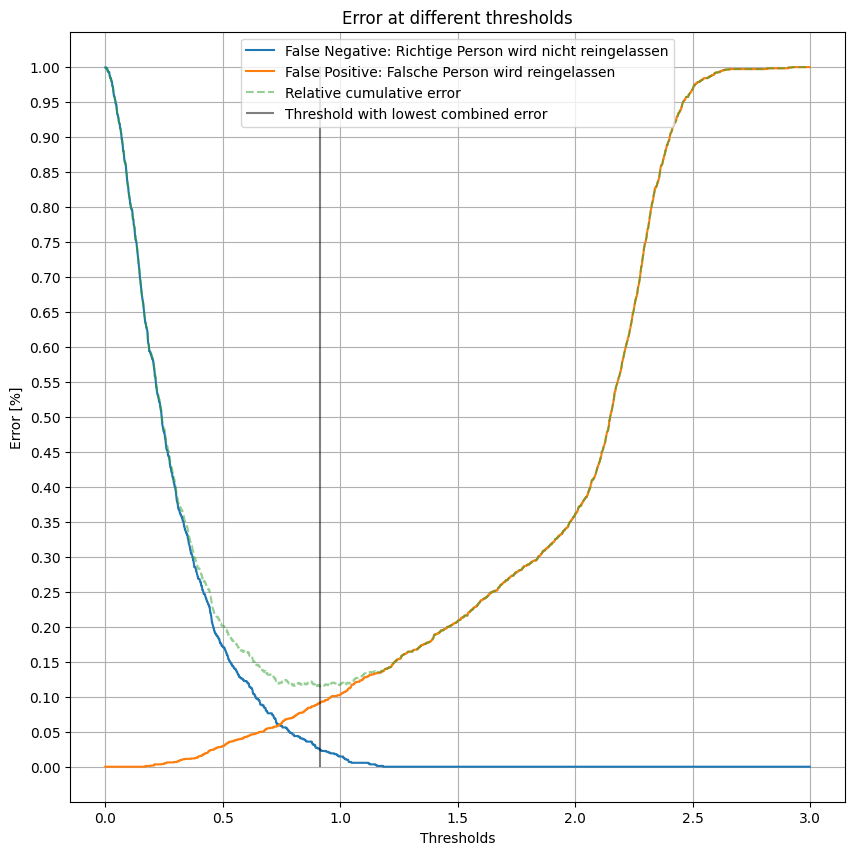

In [203]:
plt.plot(THRESHOLDS, false_negative, '-', label="False Negative: Richtige Person wird nicht reingelassen")
plt.plot(THRESHOLDS, false_positive, '-', label="False Positive: Falsche Person wird reingelassen")
plt.plot(THRESHOLDS, np.array(false_positive) + np.array(false_negative), '--', alpha = 0.5, label="Relative cumulative error")
plt.vlines([thresholds[0]], ymin=0, ymax=1, colors='k', alpha=0.5, label="Threshold with lowest combined error")
plt.yticks(np.arange(0,1.05, 0.05))
plt.title("Error at different thresholds")
plt.ylabel("Error [%]")
plt.xlabel("Thresholds")
plt.legend()
plt.grid()

## Visualisierung durch Dimensionsreduktion mit T-SNE und PCA

<p style='text-align: justify; width: 1000px;'>
Dieser Abschnitt zeigt die Visualisierung der druch das Modell generierten Repräsentationen mithilfe von TSNE und PCA. Die 128 Dimensionen werden dafür auf zwei plotbare Dimensionen reduziert. In den Plots kann gesehen werden, dass die Daten zu gleichen Personen Kluster bilden. Die PCA-Analyse kann im Gegensatz zu TSNE räumliche Zusammenhänge besser darstellen, während bei TSNE die Kluster klar differenzierbar sind. Dafür sagt die Anordnung und die Entfernung der Kluster untereinander bei TSNE nichts über die tatsächliche multidimensionale Struktur aus.

<p style='text-align: justify; width: 1000px;'>
Für die Visualisierung werden sechs Kategorien aus VGG-Face-2 verwendet, da diese im Vergleich zum Promi Datenset deutlich mehr Samples pro Kategorie bieten und sich dadurch besser für die Visualisierung der Kluster eignen. Zuerst wird aus allen Bilder die Featurerepräsentation gebildet und die zugehörige Kategorie für die Visualisierung gespeichert. Danach werden die Repräsentationen einmal durch PCA und einmal durch TSNE auf zwei Dimensionen reduziert. 

In [210]:
VIS_PATH = "./Data/TSNE/"
representations = []
categories = []

folders = [folder for folder in os.listdir(VIS_PATH) if folder!=".DS_Store"]
for folder in tqdm(folders):
    files = [file for file in os.listdir(f"./{VIS_PATH}/{folder}/") if file!=".DS_Store"]
    for file in files:
        im = read_image(file=file, path=os.path.join(VIS_PATH, folder))
        rep = encoder(preprocess_input(np.expand_dims(im, axis=0)))[0]
        representations.append(rep)
        categories.append(folder)

100%|██████████| 7/7 [01:30<00:00, 12.89s/it]


In [211]:
pca = PCA(n_components=2)
z = pca.fit_transform(np.array(representations))

df = pd.DataFrame()
df["y"] = categories
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

<p style='text-align: justify; width: 1000px;'>
Vergleicht man die Kategorien und deren Anordnung im PCA Plot kann auf Gemeinsamkeiten geschlossen werden.
<p style='text-align: justify; width: 1000px;'>
Die Ansammlung des violetten (n00590), des blauen (n000092) und des roten (n000571) Klusters sind vergleichsweise nah beieinander. Die zugehörigen Kategorien gehören zu drei verschiedene Frauen.
<p style='text-align: justify; width: 1000px;'>
Das hellgrüne (n000033) und das gelbe (n000094) Kluster weisen im PCA Plot auch eine Ähnlichkeit auf. Vergleicht man wieder die Bilder, weisen beide Personen ein östliches Erscheinungsbild auf (ich hoffe das klingt nicht rassistisch).
<p style='text-align: justify; width: 1000px;'>

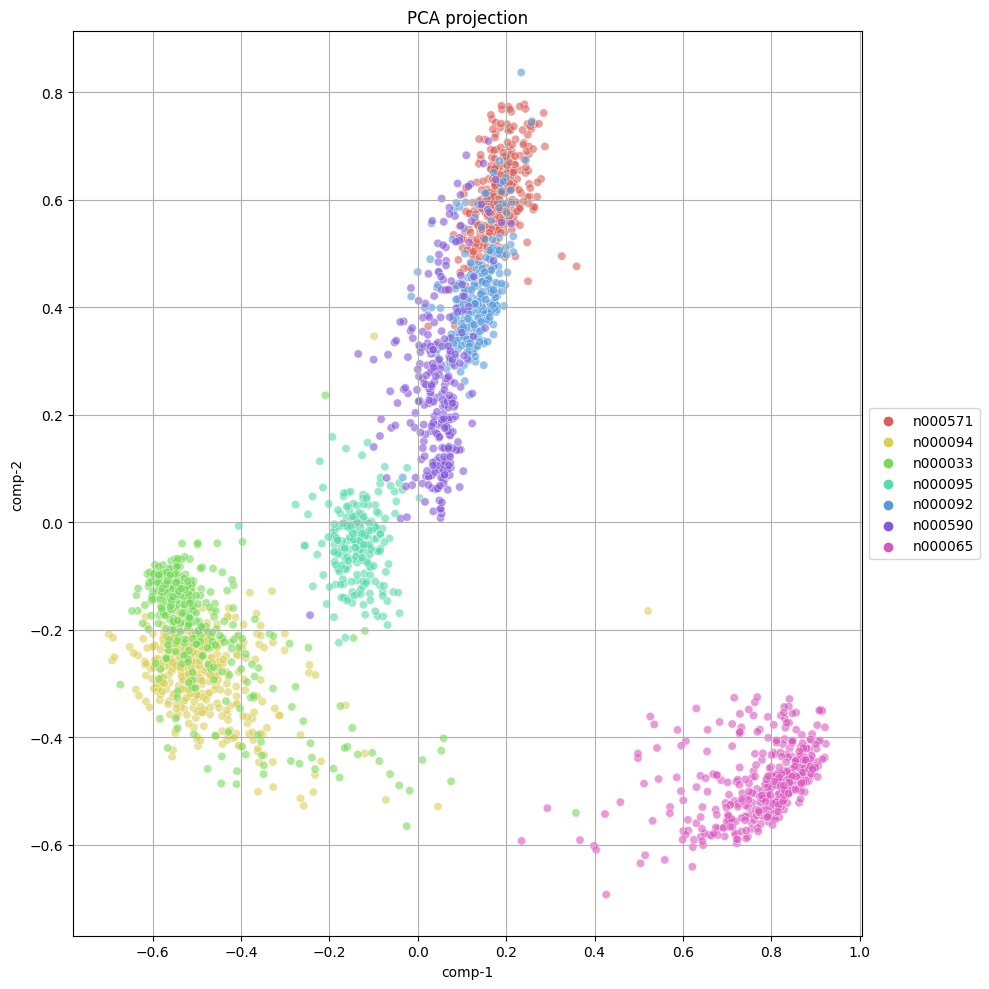

In [212]:
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(set(categories))),
                data=df, alpha=0.6)
ax.set_title(f"PCA projection")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.tight_layout()
#plt.savefig('./resources/PCA.png', dpi=600)

In [213]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', verbose=0, random_state=42)
z = tsne.fit_transform(np.array(representations))

df = pd.DataFrame()
df["y"] = categories
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

/Users/morris/miniforge3/envs/tfTL/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<p style='text-align: justify; width: 1000px;'>
Wie bereits erwähnt kann im TSNE Plot die Separierung der Kluster deutlich gesehen werden. Die Anordnung und Entfernung der Kluster zueinander hat jedoch keinen Zusammenhang zu der tatsächlichen Anordung der Daten im multidimensionalen Raum.

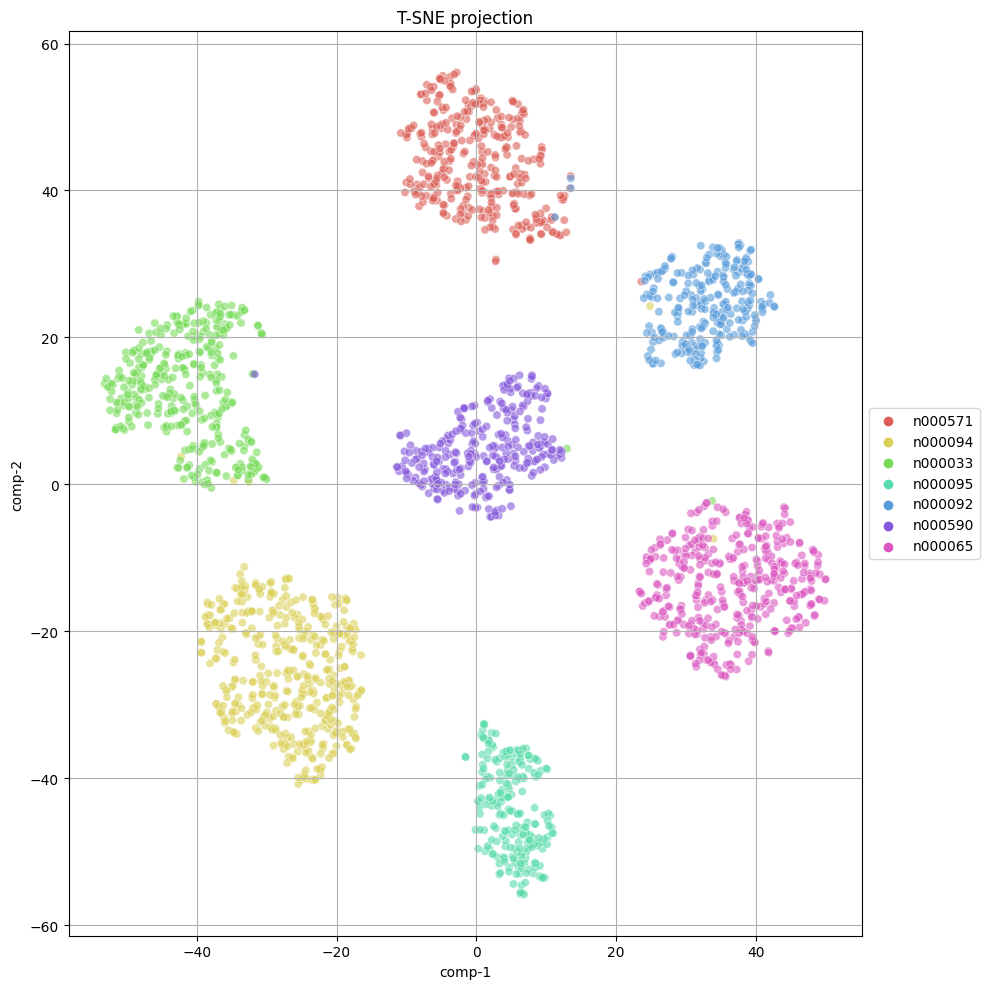

In [214]:
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(set(categories))),
                data=df, alpha=0.6)
ax.set_title(f"T-SNE projection")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.tight_layout()
#plt.savefig('./resources/TSNE.png', dpi=600)

## Analyse falscher Vorhersagen

In diesem Abschnitt werden ein paar falsche Vorhersagen veranschaulicht. Durch das Analysieren der falschen Vorhersagen können eventuell Mängel im Datenset ermittelt werden. Und Szenarien ermittelt werden, bei denen das Modell Schwierigkeiten hat.

In [215]:
ap_distances, an_distances = [], []
anchor_paths, positive_paths, negative_paths = [], [], []
for (anchor, positive, negative) in tqdm(val_triplet):

    anchor_paths.append(os.path.join(VAL_PATH, anchor))
    positive_paths.append(os.path.join(VAL_PATH, positive))
    negative_paths.append(os.path.join(VAL_PATH, negative))

    anchor = preprocess_input(np.expand_dims(read_image(anchor, path=VAL_PATH), axis=0))
    positive = preprocess_input(np.expand_dims(read_image(positive, path=VAL_PATH), axis=0))
    negative = preprocess_input(np.expand_dims(read_image(negative, path=VAL_PATH), axis=0))

    anchor_representation = encoder(anchor)
    positive_representation = encoder(positive)
    negative_representation = encoder(negative)

    ap_distances.extend(tf.reduce_sum((anchor_representation - positive_representation)**2, axis=-1).numpy())
    an_distances.extend(tf.reduce_sum((anchor_representation - negative_representation)**2, axis=-1).numpy())

100%|██████████| 1782/1782 [03:57<00:00,  7.50it/s]


In [222]:
THRESHOLD = thresholds[0] # Threshold von oben ermittelt

# Die Pfade zu den entsprechenden Bildern werden für die Visualisierung in ein Array geschrieben
false_negative = np.array(positive_paths)[np.array(ap_distances)>THRESHOLD]
false_negative_anchors = np.array(anchor_paths)[np.array(ap_distances)>THRESHOLD]
false_negative_distances = np.array(ap_distances)[np.array(ap_distances)>THRESHOLD]

false_positive = np.array(negative_paths)[np.array(an_distances)<THRESHOLD]
false_positive_anchors = np.array(anchor_paths)[np.array(an_distances)<THRESHOLD]
false_positives_distances = np.array(an_distances)[np.array(an_distances)<THRESHOLD]

In [223]:
def load_image(path): # Lädt Bilder zum Visualisieren
    image = tf.keras.preprocessing.image.load_img(path, color_mode="rgb", target_size=(300, 300), interpolation="bilinear")
    return tf.keras.preprocessing.image.img_to_array(image, dtype='float32')/255

def plot_false_negative_positive(false_anchors, false_sample, false_distance, title, N = 5):
    plt.suptitle(title)
    for i in range(1,N*2+1,2):
        plt.subplot(N ,2, i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(load_image(false_anchors[i-1]))
        plt.subplot(N ,2, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Distance {false_distance[i-1]}")
        plt.imshow(load_image(false_sample[i-1]))
    plt.tight_layout()

<p style='text-align: justify; width: 1000px;'>
Beim Betrachten der Ergebnisse können ein Paar Vermutungen aufgestellt werden.
Das Modell hat anscheinend Schwierigkeiten, wenn das Bild zu stark im Profil aufgenommen ist.
Dazu fällt auf, dass bei den False Negatives viele Beispiele dabei sind, bei denen die Person in den Bildern verschiedene Frisuren haben (Haarlänge, Haarfarbe oder überhaupt Haare). Auch extreme Belichtungsunterschiede bei den Bildern führen zu falschen Vorhersagen.

42 absolut False Negatives
1.18 % relative False Negatives
mit durchschnittlicher Distanz: 1.0317716598510742
und Standardabweichung von: 0.07297065109014511


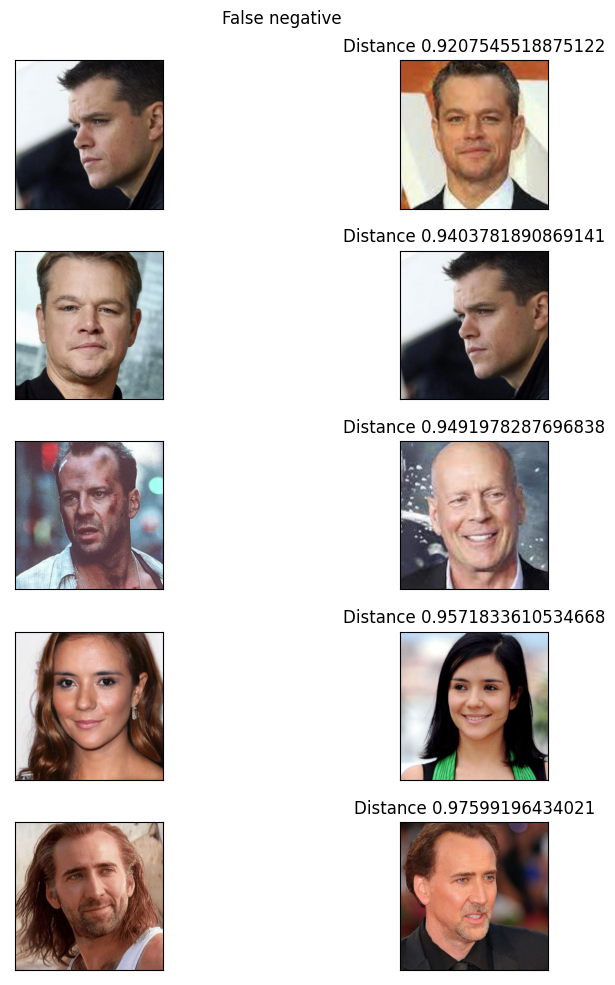

In [225]:
print(f"{len(false_negative_distances)} absolut False Negatives")
print(f"{round(len(false_negative_distances)/(len(ap_distances)+len(ap_distances))*100,2)} % relative False Negatives")
print(f"mit durchschnittlicher Distanz: {np.mean(false_negative_distances)}")
print(f"und Standardabweichung von: {np.std(false_negative_distances)}")
idx = np.argsort(false_negative_distances)
false_negative_distances = [false_negative_distances[i] for i in idx]
false_negative_anchors = [false_negative_anchors[i] for i in idx]
false_negative = [false_negative[i] for i in idx]
plot_false_negative_positive(false_negative_anchors, false_negative, false_negative_distances, title="False negative", N=5)

<p style='text-align: justify; width: 1000px;'>
Bei den False Positives ist die Visualisierung nicht so eindeutig. Ein Zusammenhang, der auffält, ist, dass Frauen mit blonden Haaren häufig als identisch erkannt werden.

162 absolut False Positives
4.55 % relative False Positives
False Positives mit durchschnittlicher Distanz: 0.6063498854637146
und Standardabweichung von: 0.1991320550441742


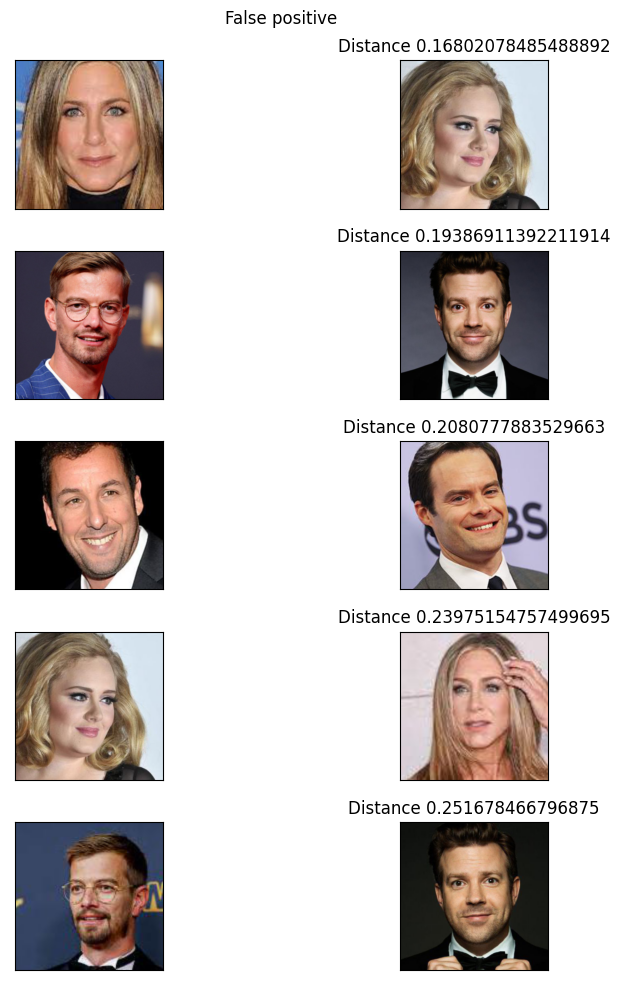

In [226]:
print(f"{len(false_positives_distances)} absolut False Positives")
print(f"{round(len(false_positives_distances)/(len(ap_distances)+len(ap_distances))*100,2)} % relative False Positives")
print(f"False Positives mit durchschnittlicher Distanz: {np.mean(false_positives_distances)}")
print(f"und Standardabweichung von: {np.std(false_positives_distances)}")
idx = np.argsort(false_positives_distances)
false_positives_distances = [false_positives_distances[i] for i in idx]
false_positive_anchors = [false_positive_anchors[i] for i in idx]
false_positive = [false_positive[i] for i in idx]
plot_false_negative_positive(false_positive_anchors, false_positive, false_positives_distances, title="False positive", N=5)

## Test mit eigenem Bild

<p style='text-align: justify; width: 1000px;'>
Zum Schluss gibt es einen Vergleich zwischen mir und einem Kommilitonen. Anhand der Distanz von 0,36 zu mir selber und einer Distanz von 1,48 zu einer anderen Person kann eindeutig gezeigt werden, dass die Repräsentationen zwischen mir "ähnlicher" sind und zwischen mir und meinem Kommilitonen "anders" sind.

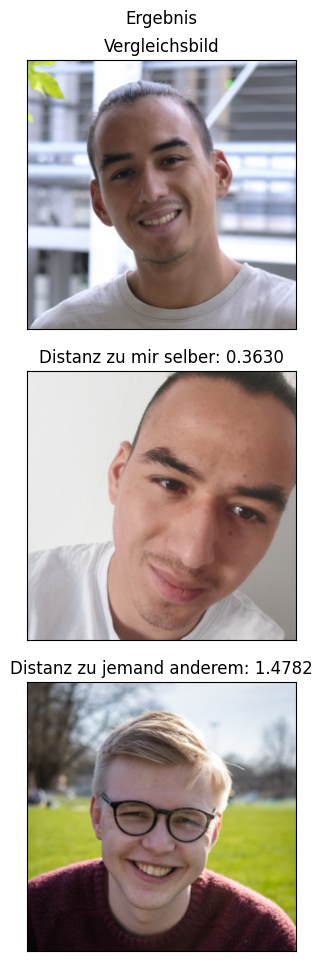

In [227]:
me = read_image("me.jpg", path="./Data/compare_images/")
me_rep = encoder(preprocess_input(np.expand_dims(me.copy(), axis=0))).numpy()[0]

me2 = read_image("me2.jpg", path="./Data/compare_images/")
me2_rep = encoder(preprocess_input(np.expand_dims(me2.copy(), axis=0))).numpy()[0]

not_me = read_image("not_me.jpg", path="./Data/compare_images/")
not_me_rep = encoder(preprocess_input(np.expand_dims(not_me.copy(), axis=0))).numpy()[0]

distance_with_myself = np.sqrt(np.sum((me_rep-me2_rep)**2))
distance_with_someone_else = np.sqrt(np.sum((me_rep-not_me_rep)**2))

plt.figure()
plt.suptitle("Ergebnis")
plt.subplot(3, 1, 1)
plt.title("Vergleichsbild")
plt.imshow(me/255)
plt.xticks([])
plt.yticks([])

plt.subplot(3, 1, 2)
plt.title(f"Distanz zu mir selber: {distance_with_myself:.4f}")
plt.imshow(me2/255)
plt.xticks([])
plt.yticks([])

plt.subplot(3, 1, 3)
plt.title(f"Distanz zu jemand anderem: {distance_with_someone_else:.4f}")
plt.imshow(not_me/255)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()
#plt.savefig("./resources/Ergebnis.png", dpi=600)

# Fazit
<p style='text-align: justify; width: 1000px;'>
In dieser Arbeit wurde ein Siamese Network für Few-Shot Gesichtsklassifizierung trainiert. Dafür wurden die Trainingsdaten in Triplets aufbereitet und ein Modell erstellt, das durch Transferlearning auf die neue Aufgabe optimiert wurde. Anschließend wurde der Trainingsverlauf, sowie die Performance des trainierten Modells analysiert. Durch tunen des Schwellenwertes konnte diese minimal verbessert werden. Zum Schluss wurden die Featurerepräsentationen durch PCA und TSNE visualisiert und mögliche Fehlerquellen und Grenzen des Modells durch Visualisieren der False Positives und False Negatives aufgezeigt.

<p style='text-align: justify; width: 1000px;'>
Aus dem Ergebnis dieses Projektes ist die Idee entstanden eine Anwendung zu erstellen, die den Benutzer über die Webcam aufnimmt und mit einem Supportset, bestehend aus prominenten Personen, vergleicht. Dadurch werden Celebrities vorgeschlagen, die dem Nutzer Ähnlich sehen. Die App wurde mit PyQt 6 geschrieben und ist in dem Zip Ordner als "Celebrity_Matching_app.py" zu finden. Das Skript create_feature_vectors_for_Celebtity_Matching.py erstellt im Voraus aus dem Supportset die Featurevektoren und speichert zu jeder Kategorie den durchschnittlichen Featurevektor zu allen Bildern ab, dass in der Anwendung nur das Webcam Bild durch das Modell verarbeitet werden muss.

# References
https://towardsdatascience.com/contrastive-loss-explaned-159f2d4a87ec <br>
https://towardsdatascience.com/triplet-loss-advanced-intro-49a07b7d8905 <br>